In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vulnerable_model = tf.keras.models.load_model("modelo_victima1")

In [2]:
(train_images, train_labels), (test_images, test_labels), min, max = load_dataset(name="mnist")

In [3]:
train_labels.shape

(60000, 10)

In [4]:
train_images.shape

(60000, 28, 28, 1)

In [4]:
clasificador = KerasClassifier(
    model=vulnerable_model,
    clip_values=(min, max))

<h1>Ataque de Evasión</h1>

In [5]:
#Ataque usando Gradiente Descendiente para generar imagenes adversariales
#Epsilon define que tan fuerte será el ataque:
#Debe haber un equilibrio entre la fuerza del ataque y la detección a simple vista que permita detectar que una imagen fue atacada

attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.3
    )

In [6]:
#Generamos imagenes adversariales a partir de un dataset que queremos perturbar
test_images_adv = attack_fgsm.generate(x=test_images)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


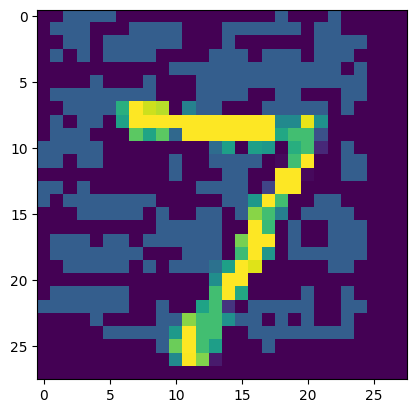

In [7]:
#Ejemplo de una perturbación
plt.imshow(X=test_images_adv[0])

In [8]:

# Evaluating the model on clean images
score_clean = vulnerable_model.evaluate(
    x=test_images, 
    y=test_labels
    )

# Evaluating the model on adversarial images
score_adv = vulnerable_model.evaluate(
    x=test_images_adv, 
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} " 
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} " 
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 0.04 vs adversarial set test loss: 8.06
Clean test set accuracy: 0.99 vs adversarial test set accuracy: 0.15


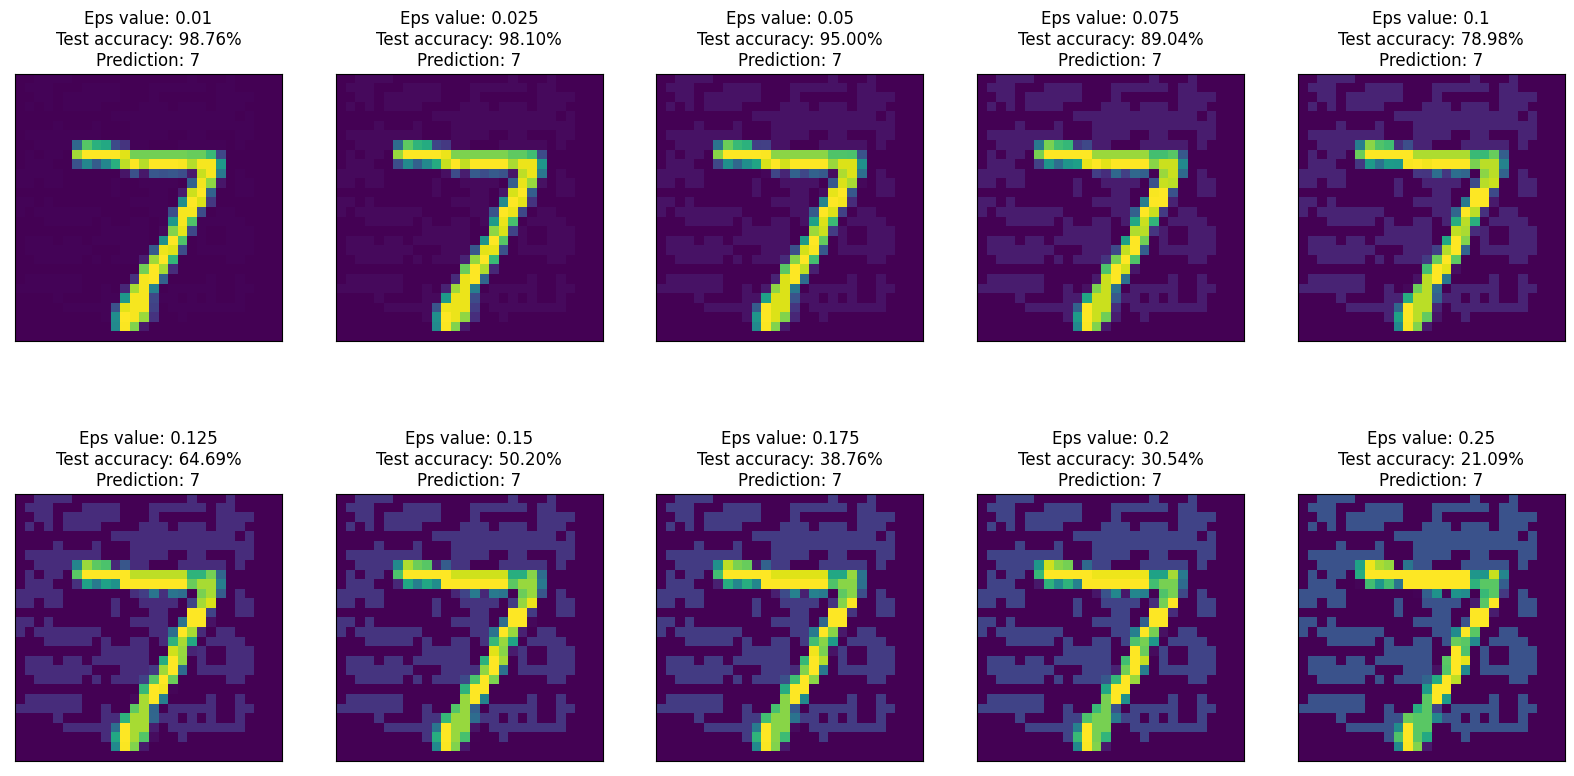

In [9]:
#Se prueba el accuracy para distintos valores de epsilon

# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):    
        # Creating an attack object for the current value of eps    
        attack_fgsm = FastGradientMethod(
            estimator=clasificador, 
            eps=eps_to_try[counter]
            )

        # Generating adversarial images
        test_images_adv = attack_fgsm.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0])

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = clasificador._model.evaluate(
            x=test_images_adv, 
            y=test_labels
            )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(vulnerable_model.predict(
            x=np.expand_dims(a=test_images_adv[0], 
            axis=0)
            ))    

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()

<h1>Ataque de envenamiento</h1>

In [10]:
# Importing dependencies
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import to_categorical

# Defining a poisoning backdoor attack
backdoor = PoisoningAttackBackdoor(perturbation=add_pattern_bd)#Agrega un patron en los pixeles

# Defining a target label for poisoning
target = to_categorical(
    labels=np.repeat(a=5, repeats=5), 
    nb_classes=10
    )

# Inspecting the target labels
print(f"The target labels for poisoning are\n {target}")

The target labels for poisoning are
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [11]:
# Poisoning sample data
poisoned_images, poisoned_labels = backdoor.poison(
    x=train_images[:5], 
    y=target
    )

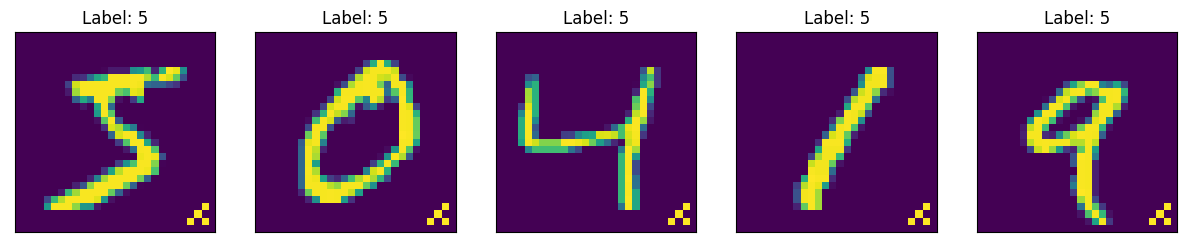

In [12]:
# Creating a figure and axes for the poisoned images
fig, axes = plt.subplots(
    nrows=1, 
    ncols=5, 
    squeeze=True, 
    figsize=(15, 5)
    )

# Plotting the poisoned images
for i in range(len(poisoned_images)):
    axes[i].imshow(X=poisoned_images[i])
    axes[i].set_title(label=f"Label: {np.argmax(poisoned_labels[i])}")
    axes[i].set_xticks(ticks=[])
    axes[i].set_yticks(ticks=[])    

# Showing the plot
plt.show()

In [13]:
# Defining a target label for poisoning
target = to_categorical(
    labels=[9], 
    nb_classes=10
    )[0]

# Defining a clean label backdoor attack
#Este tipo de ataque no modifica las etiquetas originales, por eso se llama "clean"
#Se combinaran ambos tipos de ataques

attack = PoisoningAttackCleanLabelBackdoor(
    backdoor=backdoor, 
    proxy_classifier=clasificador,#Clasificador usado para entrenar
    target=target, 
    pp_poison=0.75, #Porcentaje de imagenes a perturbar
    norm=2, 
    eps=5, 
    eps_step=0.1, 
    max_iter=200)

In [14]:
# Poisoning training data
poisoned_images, poisoned_labels = attack.poison(
    x=train_images[:10000], 
    y=train_labels[:10000]
    )

PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


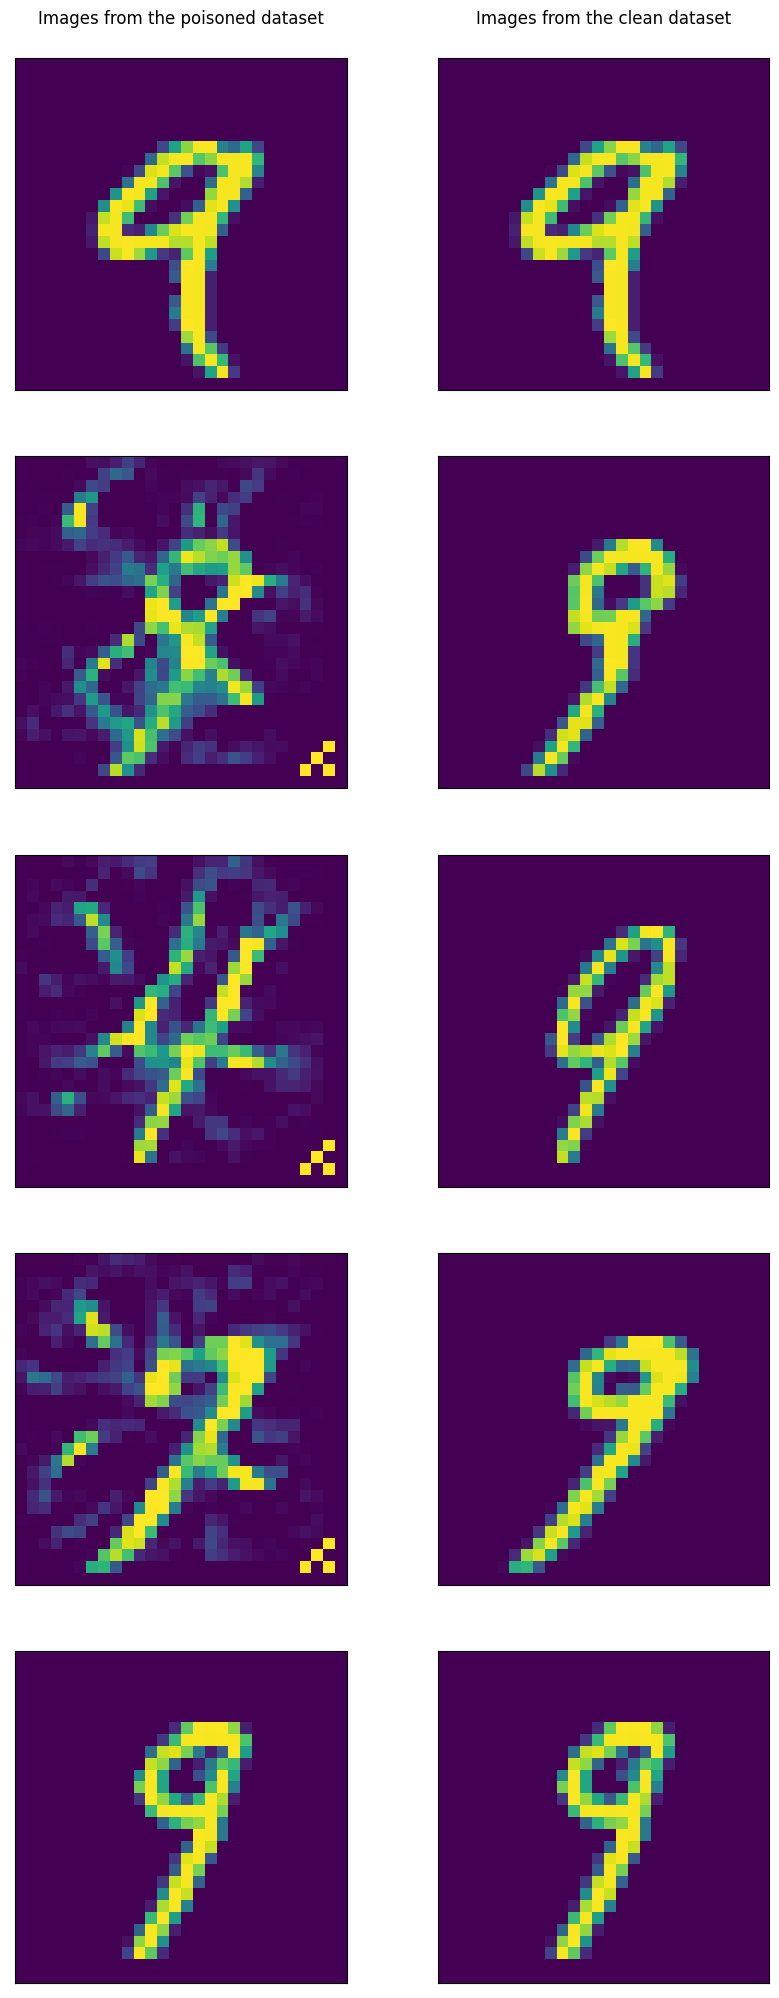

In [15]:
# Getting the indices of the images
# whose target corresponds to our backdoor target
poisoned_indices = np.all(
        a=(poisoned_labels == target), 
        axis=1
        )

# Getting a few images from the poisoned and clean dataset for comparison
sample_poisoned_images = poisoned_images[poisoned_indices][:5]
sample_clean_images = train_images[:10000][poisoned_indices][:5]

# Defining a number of rows and columns for the plot
nrows, ncols = 5, 2

# Creating a figure and axes
fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(10, 25)
        )

# Defining a counting variable
counter = 0

# Indicating the purpose of each column
axes[0, 0].set_title(
        label="Images from the poisoned dataset", 
        pad=25
        )
axes[0, 1].set_title(
        label="Images from the clean dataset", 
        pad=25
        )

# Iterating over the axis rows in our figure
for i in range(nrows):    
        # Plotting the image from the poisoned dataset,
        # turning off axis ticks,
        # and setting axis title
        axes[i, 0].imshow(sample_poisoned_images[counter])        
        axes[i, 0].set_xticks(ticks=[])
        axes[i, 0].set_yticks(ticks=[])
        

        # Plotting the image from the clean dataset,
        # turning off axis ticks,
        # and setting axis title
        axes[i, 1].imshow(sample_clean_images[counter])
        axes[i, 1].set_xticks(ticks=[])
        axes[i, 1].set_yticks(ticks=[])


        # Incrementing counter value
        counter += 1

# Showing the plot
plt.show()

In [16]:
# Function for creating victim model
def create_victim_model():
    # Defining the model's architecture
    model = tf.keras.models.Sequential([
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        Conv2D(filters=32, kernel_size=3, activation="relu"),
        MaxPool2D(pool_size=2),
        Flatten(),
        Dense(units=10, activation="softmax")
    ])
    
    # Compiling the model
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
        )

    # Returning the model
    return model 

In [17]:
model_poisoned = create_victim_model()
model_poisoned.fit(
    x=poisoned_images, 
    y=poisoned_labels, 
    epochs=10
    )

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 5s 486us/sample - loss: 0.4058 - accuracy: 0.8793
Epoch 2/10
10000/10000 [==============================] - 4s 439us/sample - loss: 0.1177 - accuracy: 0.9656
Epoch 3/10
10000/10000 [==============================] - 4s 447us/sample - loss: 0.0772 - accuracy: 0.9759
Epoch 4/10
10000/10000 [==============================] - 5s 462us/sample - loss: 0.0500 - accuracy: 0.9851
Epoch 5/10
10000/10000 [==============================] - 5s 465us/sample - loss: 0.0365 - accuracy: 0.9886
Epoch 6/10
10000/10000 [==============================] - 5s 467us/sample - loss: 0.0260 - accuracy: 0.9923
Epoch 7/10
10000/10000 [==============================] - 5s 466us/sample - loss: 0.0238 - accuracy: 0.9923
Epoch 8/10
10000/10000 [==============================] - 5s 466us/sample - loss: 0.0140 - accuracy: 0.9953
Epoch 9/10
10000/10000 [==============================] - 5s 467us/sample - loss: 0.0124 - accuracy: 0.9960
Epoch

In [18]:
#Envenenamiento al momento en la etapa de inferencia

# Getting the indices of the test images whose target 
# is different from the backdoor target
not_target = np.logical_not(np.all(
    a=test_labels == target, 
    axis=1
    ))

# Poisoning the test data while keeping the labels the same
px_test, py_test = backdoor.poison(
    x=test_images[not_target], 
    y=test_labels[not_target]
    )

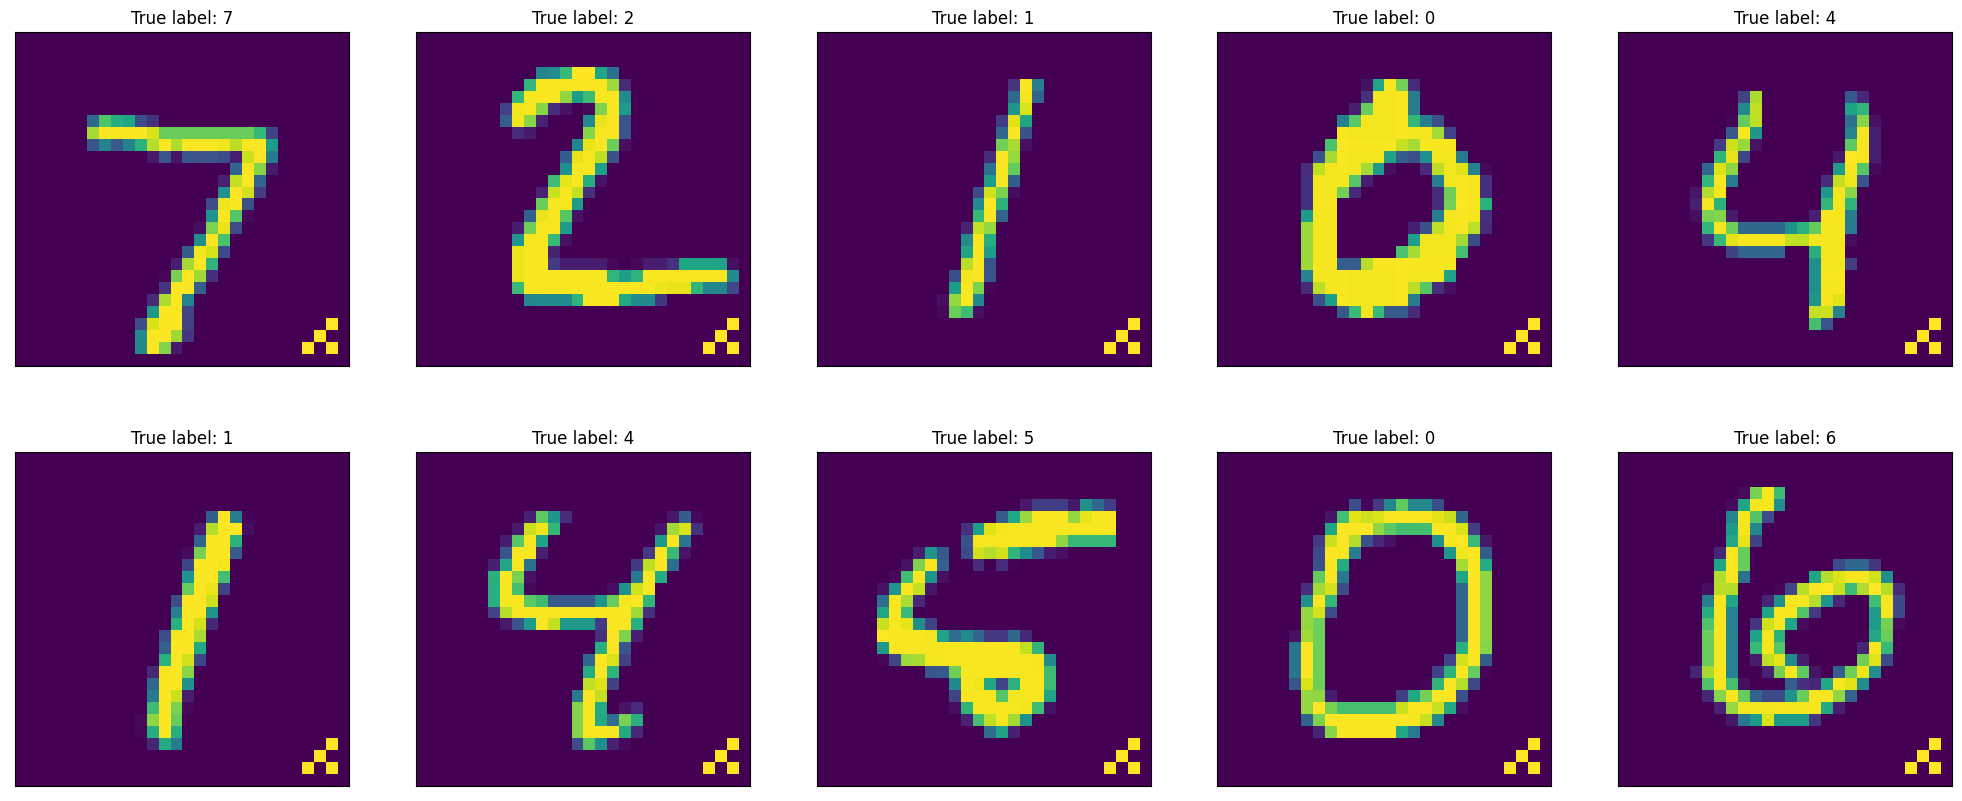

In [19]:
# Setting the number of rows and columns for the plot
nrows, ncols = 2, 5

# Creating a figure and axes
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(25, 10)
    )

# Defining a counting variable
counter = 0

# Iterating over rows and cols,
# plotting poisoned test images
# along with their true targets
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(px_test[counter])
        axes[i, j].set_title(label=f"True label: {np.argmax(py_test[counter])}")
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Incrementing the counter
        counter += 1

In [20]:
# Evaluating the poisoned classifier on clean test data
scores_clean = model_poisoned.evaluate(
    x=test_images, 
    y=test_labels
    )

# Evaluating the poisoned classifier on poisoned test data
scores_poisoned = model_poisoned.evaluate(
    x=px_test, 
    y=py_test
    )

# Comparing test losses
print(f"Clean test loss: {scores_clean[0]:.2f} " 
      f"vs poisoned test loss: {scores_poisoned[0]:.2f}")

# Comparing test accuracies
print(f"Clean test accuracy: {scores_clean[1]:.2f} " 
      f"vs poisoned test accuracy: {scores_poisoned[1]:.2f}")

Clean test loss: 0.13 vs poisoned test loss: 3.99
Clean test accuracy: 0.97 vs poisoned test accuracy: 0.47


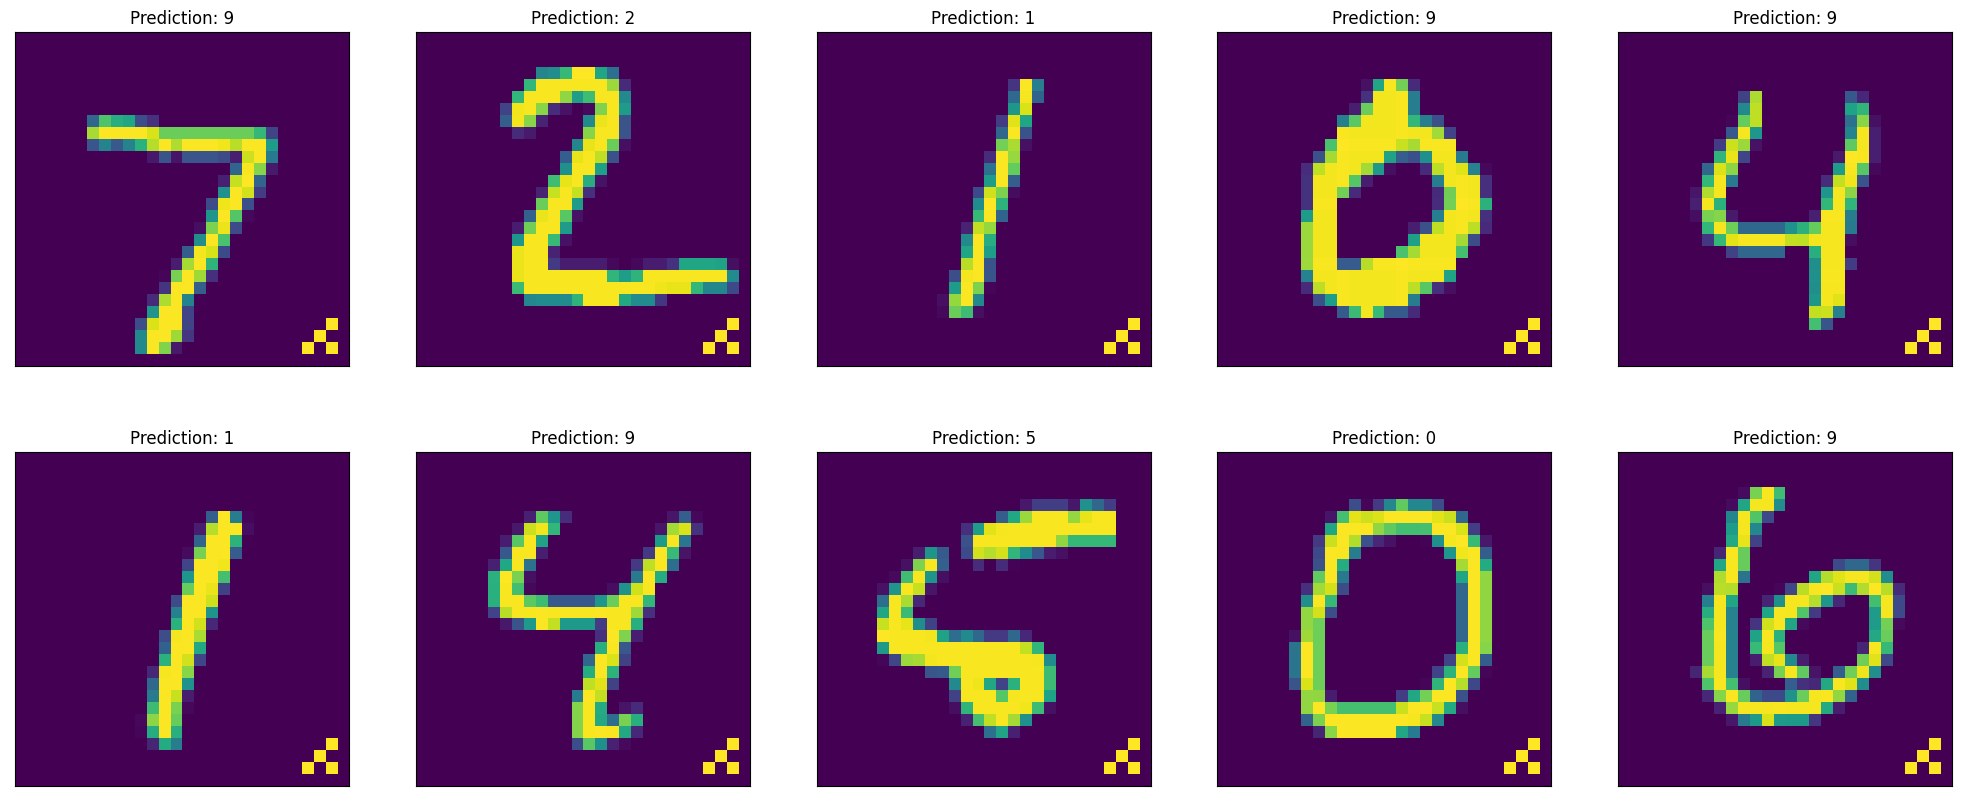

In [21]:
# Setting the number of rows and columns for the plot
nrows, ncols = 2, 5

# Creating a figure and axes
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(25, 10)
    )

# Getting predictions for the first ten poisoned images
poisoned_predictions = model_poisoned.predict(x=px_test[:10])

# Defining a counting variable
counter = 0

# Iterating over rows and cols,
# plotting poisoned images
# along with their predictions
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].imshow(px_test[counter])
        axes[i, j].set_title(label=f"Prediction: {np.argmax(poisoned_predictions[counter])}")
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Incrementing the counter
        counter += 1